In [33]:
import os
os.chdir('../')

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as tF
import numpy as np
import matplotlib.pyplot as plt

import functional as F

In [35]:
def label_to_membership(labels):
    n_class = labels.max() + 1
    n_samples = labels.shape[0]
    membership = torch.zeros(n_samples, n_class)
    for j in range(n_class):
        idx_j = labels == j
        membership[idx_j, j] = 1.
    return membership

## True MCR2 loss

In [36]:
def true_loss_discrimn(Z, eps):
    d, n = Z.shape
    I = torch.eye(d)
    return 0.5 * torch.logdet(I + d / (n * eps) * Z @ Z.T)

def true_loss_compress(Z, Pi, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    compress_loss = 0.
    for j in range(Pi.shape[1]):
        trPi = Pi[:, j].sum()
        scalar = d / (trPi * eps)
        log_det = torch.logdet(I + scalar * Z @ Pi[:, j].diag() @ Z.T)
        compress_loss += trPi / (2 * n) * log_det
    return compress_loss

## Second Variational Form

In [145]:
def var_loss_discrimn(Z, eps):
    d, n = Z.shape
    I = torch.eye(d).to(Z.device)
    return 0.5 * torch.logdet(I + d / (n * eps) * Z @ Z.T)

def var_loss_compress(Z, Pi, A, eps):
    p, m = Z.shape
    _, k = Pi.shape
    I = torch.eye(p)
    compress_loss = 0.
    r = torch.nn.ReLU()
    A = r(A)
    ones = torch.ones(A.shape[1])
    for j in range(k):
        trPi = torch.sum(Pi[:,j])
        scalar = p / (trPi * eps)
        log_det = torch.sum(ones + scalar * A[j])
        compress_loss += log_det * trPi / m
    return compress_loss / 2.

def var_reg_U(Z, Pi, A, U):
    d, m = Z.shape
    I = torch.eye(d)
    _, k = Pi.shape
    matrix_loss = 0.
    U = torch.nn.functional.normalize(U, dim = 0)
    r = torch.nn.ReLU()
    for j in range(k):
        matrix_loss += torch.norm(Z@Pi[:,j].diag()@Z.T - U@torch.diag(r(A[j]))@U.T)**2
    return  matrix_loss / 2

In [141]:
class MCR2Variational(nn.Module):
    """Equation 10 in writeup. """
    def __init__(self, eps, mu):
        super(MCR2Variational, self).__init__()
        self.eps = eps
        self.mu = mu
        
    def loss_discrimn(self, Z):
        d, n = Z.shape
        I = torch.eye(d).to(Z.device)
        return 0.5 * torch.logdet(I + d / (n * self.eps) * Z @ Z.T)

    def loss_compress(self, Z, Pi, A):
        d, m = Z.shape
        _, k= Pi.shape
        I = torch.eye(d).to(Z.device)
        compress_loss = 0.
        r = torch.nn.ReLU()
        A = r(A)
        ones = torch.ones(A.shape[1])
        for j in range(k):
            trPi = torch.sum(Pi[:,j])
            scalar = d / (trPi * eps)
            log_det = torch.sum(ones + scalar * A[j])
            compress_loss += log_det * trPi / m
        return compress_loss

    def reg_UA(self, Z, Pi, A, U):
        d, m = Z.shape
        I = torch.eye(d)
        _, k = Pi.shape
        matrix_loss = 0.
        U = torch.nn.functional.normalize(U, dim = 0)
        r = torch.nn.ReLU()
        for j in range(k):
            matrix_loss += torch.norm(Z@Pi[:,j].diag()@Z.T - U@torch.diag(r(A[j]))@U.T)**2
        return  matrix_loss / 2
    
    def forward(self, Z, Pi, A, U):
        loss_R = self.loss_discrimn(Z.T)
        loss_Rc = self.loss_compress(Z.T, Pi, A)
        loss_reg_U = self.mu * self.reg_UA(Z.T, Pi, A, U)
        loss_obj = loss_R - loss_Rc - loss_reg_U
        return -loss_obj, loss_R, loss_Rc, loss_reg_U

## Verification

In [142]:
n_class = 2
n_features = 10
n_samples = 20
eps = 0.5
mu = 0.1

In [143]:
Z_train = torch.zeros(20, 10).float()
Z_train[:10, :5] = 1.
Z_train[10:, 5:] = 1.
Z_train = F.normalize(Z_train)
Pi = torch.zeros(20, 2)
Pi[:10, 0] = 1.
Pi[10:, 1] = 1.

In [164]:
eps = 0.5
mu = 1
r = n_features

criterion_mcr2var = MCR2Variational(eps, mu)
U = nn.Parameter(
    torch.randn(n_features, r),
    requires_grad=True
    )
A = nn.Parameter(
    torch.randn(n_class, r),
    requires_grad=True
    )
import torch.optim as optim
optimizer = optim.SGD([A, U], lr=0.005)

In [165]:
for epoch in range(10000):
    optimizer.zero_grad()
    loss_obj, loss_R, loss_Rc, loss_reg_U = criterion_mcr2var(Z_train, Pi, A, U)
    if epoch % 100 == 0:
        print(epoch, -loss_obj.item(), loss_R.item(), loss_Rc.item(), loss_reg_U.item())
    loss_obj.backward()
    optimizer.step()

0 -115.84086608886719 2.397895336151123 19.987585067749023 98.25117492675781
100 -76.51814270019531 2.397895336151123 19.51251792907715 59.40351867675781
200 -69.28280639648438 2.397895336151123 20.106748580932617 51.573951721191406
300 -68.15409851074219 2.397895336151123 19.707988739013672 50.84400177001953
400 -67.71141052246094 2.397895336151123 19.400100708007812 50.709205627441406
500 -67.45036315917969 2.397895336151123 19.17813491821289 50.670127868652344
600 -67.27432250976562 2.397895336151123 19.0203800201416 50.65183639526367
700 -67.1954574584961 2.397895336151123 19.022184371948242 50.571170806884766
800 -67.16602325439453 2.397895336151123 19.021615982055664 50.542301177978516
900 -67.14603424072266 2.397895336151123 19.007450103759766 50.53647994995117
1000 -67.1314697265625 2.397895336151123 18.994909286499023 50.534454345703125
1100 -67.12018585205078 2.397895336151123 18.984865188598633 50.5332145690918
1200 -67.11084747314453 2.397895336151123 18.9764347076416 50.53

In [167]:
U = torch.nn.functional.normalize(U, dim = 0).detach()
r = torch.nn.ReLU()
A = r(A).detach()

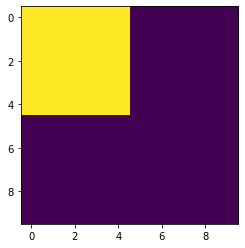

In [168]:
plt.imshow(U@r(A[0]).diag()@U.T)

In [149]:
## Just Matrix approx
eps = 0.5
mu = 1
r = n_features

U = nn.Parameter(
    torch.randn(n_features, r),
    requires_grad=True
    )
A = nn.Parameter(
    torch.randn(n_class, r),
    requires_grad=True
    )
import torch.optim as optim
optimizer = optim.SGD([A, U], lr=0.005)
for epoch in range(4000):
    optimizer.zero_grad()
    loss = var_reg_U(Z_train.T, Pi, A, U)
    print(epoch, loss.item())
    loss.backward()
    optimizer.step()

0 100.1887435913086
1 99.90270233154297
2 99.61534118652344
3 99.32650756835938
4 99.03593444824219
5 98.74346923828125
6 98.44891357421875
7 98.15205383300781
8 97.85263061523438
9 97.5505142211914
10 97.24543762207031
11 96.93724060058594
12 96.62557983398438
13 96.31037902832031
14 95.99131774902344
15 95.6681900024414
16 95.34074401855469
17 95.00877380371094
18 94.67205047607422
19 94.33023071289062
20 93.98313903808594
21 93.63050842285156
22 93.2720947265625
23 92.9075927734375
24 92.53680419921875
25 92.15943908691406
26 91.77523803710938
27 91.38392639160156
28 90.98524475097656
29 90.57890319824219
30 90.1646728515625
31 89.7422866821289
32 89.31147766113281
33 88.87206268310547
34 88.42366790771484
35 87.9661865234375
36 87.49932098388672
37 87.02293395996094
38 86.5367431640625
39 86.0406494140625
40 85.534423828125
41 85.01793670654297
42 84.49105834960938
43 83.95376586914062
44 83.40583801269531
45 82.84732055664062
46 82.2781982421875
47 81.69845581054688
48 81.10815429

427 1.088932991027832
428 1.080033779144287
429 1.0712254047393799
430 1.0625008344650269
431 1.0538604259490967
432 1.0453057289123535
433 1.0368331670761108
434 1.0284452438354492
435 1.020139217376709
436 1.011932373046875
437 1.0038493871688843
438 0.9958452582359314
439 0.9879180192947388
440 0.9800677299499512
441 0.972293496131897
442 0.9645940065383911
443 0.9569698572158813
444 0.9494202136993408
445 0.9419422149658203
446 0.9345359802246094
447 0.9272015690803528
448 0.9199380874633789
449 0.9127447009086609
450 0.9056190252304077
451 0.8985630869865417
452 0.8915742039680481
453 0.8846529126167297
454 0.8777976036071777
455 0.8710083961486816
456 0.8642845153808594
457 0.8576236963272095
458 0.8510268926620483
459 0.8444940447807312
460 0.8380231857299805
461 0.8316134810447693
462 0.8252630829811096
463 0.8189753293991089
464 0.8127475380897522
465 0.8065795302391052
466 0.8004698157310486
467 0.7944164872169495
468 0.7884243130683899
469 0.7824852466583252
470 0.7766034007

865 0.11201011389493942
866 0.11165751516819
867 0.11130626499652863
868 0.11095668375492096
869 0.11060875654220581
870 0.11026248335838318
871 0.10991748422384262
872 0.10957437753677368
873 0.10923299193382263
874 0.10889296233654022
875 0.10855452716350555
876 0.10821758210659027
877 0.10788212716579437
878 0.10754833370447159
879 0.10721556842327118
880 0.1068846806883812
881 0.1065552681684494
882 0.1062273383140564
883 0.10590106248855591
884 0.10557588189840317
885 0.10525237023830414
886 0.10493036359548569
887 0.10460972785949707
888 0.10429047048091888
889 0.1039726510643959
890 0.10365638136863708
891 0.10334151983261108
892 0.10302795469760895
893 0.10271550714969635
894 0.10240492224693298
895 0.10209541767835617
896 0.10178732872009277
897 0.10148059576749802
898 0.1011752113699913
899 0.10087092220783234
900 0.10056836158037186
901 0.10026675462722778
902 0.09996664524078369
903 0.09966779500246048
904 0.09937029331922531
905 0.09907406568527222
906 0.09877905249595642


1310 0.036645226180553436
1311 0.03656885772943497
1312 0.036492668092250824
1313 0.03641672804951668
1314 0.03634093701839447
1315 0.03626536205410957
1316 0.03619005158543587
1317 0.036114830523729324
1318 0.03603997454047203
1319 0.03596522659063339
1320 0.03589065372943878
1321 0.03581634536385536
1322 0.03574219346046448
1323 0.035668276250362396
1324 0.03559453412890434
1325 0.035520996898412704
1326 0.03544767200946808
1327 0.035374607890844345
1328 0.03530169650912285
1329 0.03522887080907822
1330 0.03515629842877388
1331 0.03508394956588745
1332 0.03501188009977341
1333 0.03493989259004593
1334 0.034868113696575165
1335 0.03479650616645813
1336 0.034725114703178406
1337 0.03465386480093002
1338 0.034582968801259995
1339 0.03451202064752579
1340 0.03444143384695053
1341 0.0343710258603096
1342 0.03430075943470001
1343 0.03423077240586281
1344 0.03416083753108978
1345 0.03409113362431526
1346 0.034021712839603424
1347 0.03395245596766472
1348 0.033883318305015564
1349 0.03381437

1747 0.016422213986516
1748 0.01639558933675289
1749 0.016369041055440903
1750 0.016342561691999435
1751 0.01631617173552513
1752 0.01628977246582508
1753 0.01626349799335003
1754 0.01623723842203617
1755 0.016211066395044327
1756 0.016184955835342407
1757 0.01615884155035019
1758 0.016132812947034836
1759 0.016106849536299706
1760 0.016080936416983604
1761 0.016055069863796234
1762 0.016029268503189087
1763 0.016003506258130074
1764 0.015977835282683372
1765 0.01595218852162361
1766 0.015926597639918327
1767 0.015901081264019012
1768 0.015875594690442085
1769 0.01585017517209053
1770 0.015824779868125916
1771 0.01579950377345085
1772 0.015774216502904892
1773 0.015749000012874603
1774 0.01572386361658573
1775 0.015698738396167755
1776 0.015673723071813583
1777 0.015648726373910904
1778 0.015623793937265873
1779 0.015598899684846401
1780 0.015574091114103794
1781 0.015549283474683762
1782 0.015524552203714848
1783 0.015499874949455261
1784 0.01547525729984045
1785 0.015450669452548027


2165 0.00892112497240305
2166 0.008909398689866066
2167 0.008897700347006321
2168 0.008886015973985195
2169 0.008874346502125263
2170 0.008862713351845741
2171 0.008851085789501667
2172 0.008839480578899384
2173 0.008827893063426018
2174 0.008816337212920189
2175 0.008804796263575554
2176 0.00879327766597271
2177 0.008781797252595425
2178 0.008770322427153587
2179 0.008758863434195518
2180 0.00874742679297924
2181 0.008735992945730686
2182 0.008724594488739967
2183 0.008713234215974808
2184 0.00870187021791935
2185 0.008690527640283108
2186 0.008679204620420933
2187 0.00866788811981678
2188 0.008656610734760761
2189 0.008645374327898026
2190 0.008634134195744991
2191 0.008622916415333748
2192 0.008611716330051422
2193 0.008600538596510887
2194 0.008589383214712143
2195 0.00857823807746172
2196 0.008567111566662788
2197 0.008555999957025051
2198 0.008544925600290298
2199 0.008533849380910397
2200 0.008522819727659225
2201 0.008511791005730629
2202 0.00850079394876957
2203 0.008489822968

2580 0.005420642904937267
2581 0.005414717830717564
2582 0.00540876854211092
2583 0.005402854643762112
2584 0.0053969454020261765
2585 0.005391040351241827
2586 0.005385153461247683
2587 0.005379260517656803
2588 0.005373398773372173
2589 0.0053675249218940735
2590 0.005361654330044985
2591 0.005355804692953825
2592 0.0053499541245400906
2593 0.005344115663319826
2594 0.005338299088180065
2595 0.005332472734153271
2596 0.005326659418642521
2597 0.005320859141647816
2598 0.005315079819411039
2599 0.005309279542416334
2600 0.00530351884663105
2601 0.005297758150845766
2602 0.005292007699608803
2603 0.005286266095936298
2604 0.005280518904328346
2605 0.005274796858429909
2606 0.005269073881208897
2607 0.00526334997266531
2608 0.005257667042315006
2609 0.005251967813819647
2610 0.0052462792955338955
2611 0.005240591708570719
2612 0.005234920885413885
2613 0.005229258444160223
2614 0.005223607644438744
2615 0.0052179573103785515
2616 0.005212315358221531
2617 0.00520669249817729
2618 0.0052

2977 0.0036232632119208574
2978 0.0036198643501847982
2979 0.0036164592020213604
2980 0.0036130675580352545
2981 0.0036096780095249414
2982 0.0036063010338693857
2983 0.0036029203329235315
2984 0.003599548479542136
2985 0.0035961782559752464
2986 0.0035928126890212297
2987 0.003589445957913995
2988 0.003586091799661517
2989 0.003582742065191269
2990 0.003579387441277504
2991 0.0035760398022830486
2992 0.003572702407836914
2993 0.00356937269680202
2994 0.003566029714420438
2995 0.003562697907909751
2996 0.0035593772772699594
2997 0.0035560582764446735
2998 0.00355274835601449
2999 0.003549436340108514
3000 0.0035461261868476868
3001 0.0035428230185061693
3002 0.0035395289305597544
3003 0.0035362376365810633
3004 0.0035329449456185102
3005 0.003529658541083336
3006 0.0035263760946691036
3007 0.003523104591295123
3008 0.0035198291298002005
3009 0.003516562981531024
3010 0.003513295901939273
3011 0.0035100432578474283
3012 0.003506779670715332
3013 0.003503537504002452
3014 0.0035002974327

3370 0.002568267984315753
3371 0.0025661764666438103
3372 0.0025640828534960747
3373 0.002561994129791856
3374 0.0025599044747650623
3375 0.002557826228439808
3376 0.00255573820322752
3377 0.0025536618195474148
3378 0.002551582409068942
3379 0.0025495083536952734
3380 0.002547429408878088
3381 0.002545365132391453
3382 0.0025432980619370937
3383 0.0025412249378859997
3384 0.0025391634553670883
3385 0.0025371075607836246
3386 0.0025350500363856554
3387 0.002532993210479617
3388 0.0025309391785413027
3389 0.002528890036046505
3390 0.0025268399622291327
3391 0.0025247957091778517
3392 0.0025227449368685484
3393 0.0025207102298736572
3394 0.002518666675314307
3395 0.002516635460779071
3396 0.002514597959816456
3397 0.002512565115466714
3398 0.0025105357635766268
3399 0.002508510136976838
3400 0.0025064805522561073
3401 0.0025044598150998354
3402 0.002502444200217724
3403 0.00250042462721467
3404 0.00249840528704226
3405 0.0024963903706520796
3406 0.0024943817406892776
3407 0.00249237474054

3779 0.0018811392365023494
3780 0.00187980430200696
3781 0.0018784691346809268
3782 0.001877143164165318
3783 0.0018758111400529742
3784 0.0018744840053841472
3785 0.0018731530290096998
3786 0.0018718225182965398
3787 0.0018705062102526426
3788 0.001869179424829781
3789 0.0018678578780964017
3790 0.001866541220806539
3791 0.0018652245635166764
3792 0.0018639034824445844
3793 0.0018625890370458364
3794 0.0018612716812640429
3795 0.0018599589820951223
3796 0.0018586439546197653
3797 0.0018573339330032468
3798 0.0018560269381850958
3799 0.0018547194777056575
3800 0.0018534093396738172
3801 0.0018521042075008154
3802 0.0018508044304326177
3803 0.001849497202783823
3804 0.0018481956794857979
3805 0.0018468936905264854
3806 0.0018455986864864826
3807 0.0018442970467731357
3808 0.0018430042546242476
3809 0.0018417082028463483
3810 0.0018404144793748856
3811 0.001839122618548572
3812 0.0018378316890448332
3813 0.0018365442520007491
3814 0.0018352580955252051
3815 0.001833972055464983
3816 0.00

In [158]:
U = torch.nn.functional.normalize(U, dim = 0).detach()
r = torch.nn.ReLU()
A = r(A).detach()

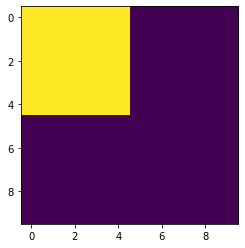

In [160]:
plt.imshow(U@r(A[0]).diag()@U.T)

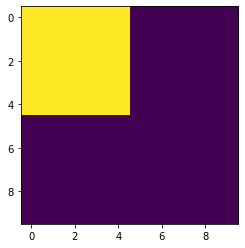

In [162]:
plt.imshow(Z@Pi[:,0].diag()@Z.T)

In [155]:
Z = Z_train.T
r = torch.nn.ReLU()
print(A.shape)
print(U.shape)
print(U@r(A[0]).diag()@U.T)

torch.Size([2, 10])
torch.Size([10, 10])
tensor([[ 2.0000e+00,  2.0002e+00,  1.9998e+00,  1.9996e+00,  1.9996e+00,
         -7.9292e-05,  3.5641e-05,  3.4368e-05, -2.6720e-04,  3.9427e-04],
        [ 2.0002e+00,  2.0005e+00,  1.9998e+00,  1.9993e+00,  1.9994e+00,
         -1.5402e-04,  7.6712e-05,  7.1866e-05, -5.2371e-04,  7.9561e-04],
        [ 1.9998e+00,  1.9998e+00,  1.9999e+00,  1.9999e+00,  1.9999e+00,
          2.5960e-05,  2.5549e-07, -3.1102e-06,  7.9981e-05, -8.1656e-05],
        [ 1.9996e+00,  1.9993e+00,  1.9999e+00,  2.0003e+00,  2.0002e+00,
          1.2905e-04, -6.1028e-05, -5.7998e-05,  4.3677e-04, -6.5371e-04],
        [ 1.9996e+00,  1.9994e+00,  1.9999e+00,  2.0002e+00,  2.0001e+00,
          8.3680e-05, -5.3826e-05, -4.7341e-05,  2.9218e-04, -4.8059e-04],
        [-7.9292e-05, -1.5402e-04,  2.5960e-05,  1.2905e-04,  8.3680e-05,
          4.5852e-05, -5.3184e-06, -9.4329e-06,  1.4489e-04, -1.6717e-04],
        [ 3.5641e-05,  7.6712e-05,  2.5549e-07, -6.1028e-05, -5.3